Resizing training, test images and masks
Done with test and train image resizing
X_test


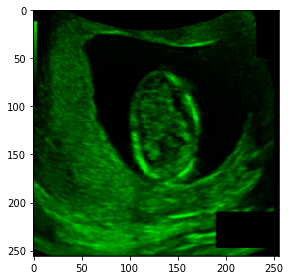

X_train


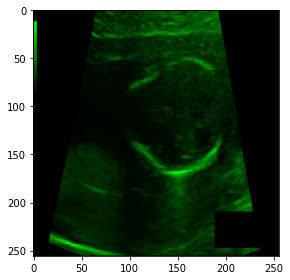

Y_train


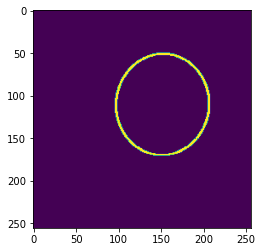

In [12]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
from keras import backend as keras
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob

np.random.seed = 42

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_RAW_PATH = 'Images/Head/head_training_set/hc_raw'
TRAIN_MASK_PATH = 'Images/Head/head_training_set/hc_mask/*.png'
TEST_PATH = 'Images/Head/head_test_set/'

# train_raw_data = os.walk(TRAIN_RAW_PATH)[1]
# train_mask_data = os.walk(TRAIN_MASK_PATH)[1]
# test_data = os.walk(TEST_PATH)[1]

# X_train = np.zeros((len(train_raw_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_mask_data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
# X_test = np.zeros((len(test_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

X_train = np.zeros((999, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((999, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((335, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print("Resizing training, test images and masks")

index_counter = 0
for rawImage in os.listdir(TRAIN_RAW_PATH):
    image = io.imread(os.path.join(TRAIN_RAW_PATH, rawImage))
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_train[index_counter]=image
    index_counter+=1

index_counter = 0

# for maskImage in os.listdir(TRAIN_MASK_PATH):
#     image = io.imread(os.path.join(TRAIN_MASK_PATH, maskImage), pilmode="RGB")
#     image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
#     Y_train[index_counter]=image
#     index_counter+=1
    
for maskImage in glob(TRAIN_MASK_PATH):
    image = io.imread(maskImage)
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[index_counter]=image
    index_counter+=1
    
index_counter = 0

for img in os.listdir(TEST_PATH):
    image = io.imread(os.path.join(TEST_PATH, img))
    image = trans.resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    X_test[index_counter]=image
    index_counter+=1
    
    
print("Done with test and train image resizing")

index = np.random.randint(0, 335)
print('X_test')
io.imshow(X_test[index])
plt.show()
print('X_train')
io.imshow(X_train[index])
plt.show()
print('Y_train')
plt.imshow(np.squeeze(Y_train[index]))

input_size = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

inputs = Input(input_size)
float_inputs = Lambda(lambda x:x / 511)(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(float_inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = Dropout(0.3)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
drop6 = Dropout(0.4)(conv6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([drop3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
drop7 = Dropout(0.3)(conv7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([drop2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
drop8 = Dropout(0.2)(conv8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([drop1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
drop9 = Dropout(0.2)(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

checkpoint = ModelCheckpoint('model_for_hc.h5', verbose=1, save_best_only=True)
callbacks = [EarlyStopping(patience=2, monitor="val_loss"), TensorBoard(log_dir="logs")]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=callbacks)

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

for i,item in enumerate(preds_test):
    io.imsave(os.path.join("Images/Head/head_result","%d_HC_predict.png"%i),item)

ix = np.random.randint(0, len(preds_train_t))
print("Showing X_train")
io.imshow(X_train[ix])
plt.show()
print("Showing Y_train")
plt.imshow(np.squeeze(Y_train[ix]))
print("Showing preds_train_t")
io.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = np.random.randint(0, len(preds_val_t))
print("Showing X_train after shaping")
io.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
print("Showing Y_train after shaping")
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
print("Showing preds_val_t")
io.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model